# Ukraine war news analysis

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import scipy
# from dtaidistance import dtw
import pyeasytrend

In [2]:
#Days of interest. Change the range here to study only a certain amount of time (e.g. 1 month)
firstDay = '2022-02-24'
lastDay = '2022-03-24'

KEYWORDS = ['bambino','bambina','bambini','neonati','neonata','neonato','child','children','infants', 'toddler', 'toddlers','infant','kid','kids']
KEYWORDSADULTS = ['uomo','donna','uomini','man','woman','men','women']
KEYDEATH = ['morte','morti','morto','cadaveri','cadavere','uccisi','ucciso','giustiziato','giustiziati',
           'death','deaths','killed','kill','corpse','casualty']

In [3]:
url = '/home/giulio/Repositories/ukrainenewsscraper/Processed/db.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,Title,url,Date,Article,Source,ID,Language
0,0,"Wsj: ""Ue ha proposto di sanzionare anche le fi...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:19:00,La Ue ha proposto di sanzionare anche le due f...,TGCOM24,0,it
1,1,"Usa sanzionano Hydra, maggiore piattaforma del...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:01:00,"Gli Usa hanno sanzionato Hydra, la più grande ...",TGCOM24,1,it
2,2,Casa Bianca: nuove sanzioni a dirigenti govern...,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:42:00,Le nuove sanzioni Usa colpiranno dirigenti del...,TGCOM24,2,it
3,3,"Bucha, la Russia si difende dalle accuse | In ...",https://www.tgcom24.mediaset.it/mondo/ucraina-...,2022-04-05 22:20:26,"La Nato: ""Fase cruciale, Mosca vuole il Donbas...",TGCOM24,3,it
4,4,Esplosioni udite nella regione di Leopoli,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:20:00,Esplosioni sono state udite nell'ovest dell'Uc...,TGCOM24,4,it


In [4]:
url = '/home/giulio/Repositories/ukrainenewsscraper/Processed/dbCasualties.csv'
dfCasualties = pd.read_csv(url)
dfCasualties.head()
#TODO Clean text in 02/26. check if growth is linear/cubic/quadratic, if so may be wort trying reconstring missing data points
#TODO Can we import pyeasytrends in colab?

,Day,totalDeaths,AdultsDeaths,ChildrenDeaths,total injured,adults injured,children injured,totalEvacuee,AdultsEvacuee,ChildrenEvacuee,ItalyTotalRefugees,ItalyAdultsRefugess,ItalyChildrenRefugees
0,2/24/2022,NaN,NaN,NaN,NaN,NaN,NaN,79034.0,NaN,NaN,NaN,NaN,NaN
1,2/25/2022,NaN,NaN,NaN,NaN,NaN,NaN,115157.0,NaN,NaN,NaN,NaN,NaN
2,2/26/2022,NaN,NaN,NaN,NaN,NaN,NaN,150472.0,NaN,NaN,NaN,NaN,NaN
3,2/27/2022,102.0,95.0,7.0,304.0,283.0,21.0,171080.0,NaN,NaN,NaN,NaN,NaN
4,2/28/2022,40.0,34.0,6.0,104.0,99.0,5.0,156771.0,NaN,NaN,NaN,NaN,NaN


# Data reconstruction

The dataset has missing data point at the beginning. If the data follow a trend, we can estimate the previous points.
We can perform a trend analysis to verify whether a model can represent obtained data.

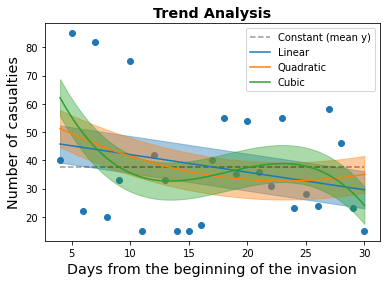

,Order,R2,SSE,F,pvalue,AIC,BIC
0,1,0.058775,10191.589133,1.561118,0.223073,238.826673,240.122510
1,2,0.077336,9990.602383,0.482822,0.493820,240.288890,242.880564
2,3,0.144440,9264.008415,1.803934,0.192342,240.250172,244.137683


In [5]:
totalDeaths = dfCasualties.loc[4:].totalDeaths.astype(int).to_list()

dates = list(range(4, len(totalDeaths)+4))

# https://github.com/Gabrock94/pyEasyTrend
results = pyeasytrend.analyzeTrend(dates, totalDeaths, maxDegree=3, visualize=True, xlabel='Days from the beginning of the invasion', ylabel='Number of casualties')
pyeasytrend.tablifyResults(results)

# Data do not follow a specific model.

We can't reliably reconstruct the data. We will skip the first days during the analysis.

In [6]:
adultDeaths = dfCasualties.loc[4:].AdultsDeaths.astype(int).to_list()
childrenDeaths = dfCasualties.loc[4:].ChildrenDeaths.astype(int).to_list()

# Exploratory Analysis

## How many articles are we looking at? In which language have they been written? What are the sources?

In [7]:
#time period to study
df = df[(pd.to_datetime(df.Date) > pd.to_datetime(firstDay)) & (pd.to_datetime(df.Date) < pd.to_datetime(lastDay))]
print(len(df), 'Valid articles in selected dates range')

3421 Valid articles in selected dates range


TGCOM24    2255
Open        660
cna         462
ilpost       44
Name: Source, dtype: int64

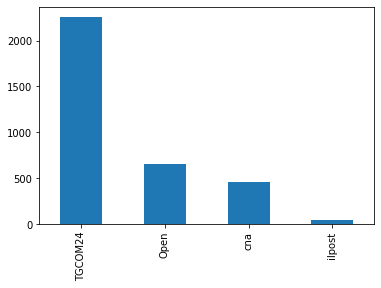

In [8]:
#How many articles per source?
df.Source.value_counts().plot.bar()
df.Source.value_counts()

([<matplotlib.axis.XTick at 0x7f454a024cd0>,
 [Text(0, 0, 'Italian'), Text(1, 0, 'English')])

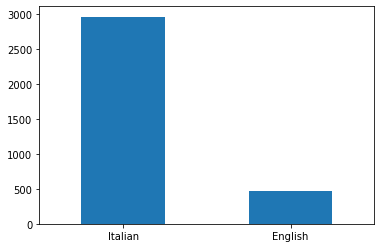

In [9]:
#How many articles per language?
df.Language.value_counts().plot.bar()
df.Language.value_counts()
plt.xticks([0,1],['Italian','English'], rotation=0)

In [10]:
#Create a date only field, move datetime to datetime field
df = df.assign(Datetime = df.Date)
df.Date = pd.to_datetime(df['Date']).dt.date

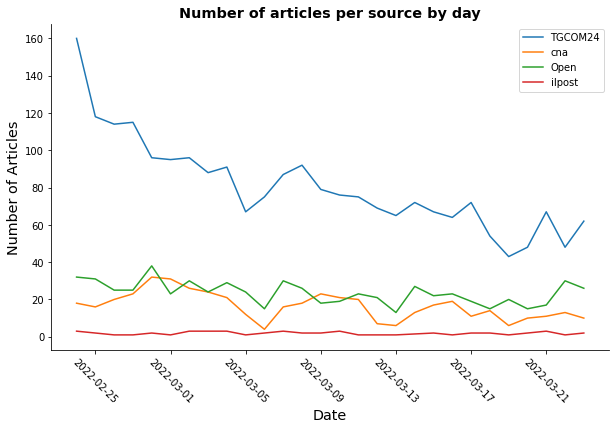

In [11]:
#see the number of articles by source
plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for source in df.Source.unique():
    t = pd.DataFrame(df[df.Source == source].Date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
    plt.plot(t.Date, t.Count, label=source)
    
plt.xticks(rotation=-45)
plt.xlabel('Date',fontsize='x-large')
plt.ylabel('Number of Articles',fontsize='x-large')
plt.title('Number of articles per source by day', weight='bold', fontsize='x-large')
plt.legend()
plt.savefig('Figures/articlesperdaybysource.png', dpi=300)

# Let's dig into the hypothesis.
Identify articles that talk about either adults/children and deaths.


In [12]:
# Rapid Analysis:
df = df.assign(hasKeyword = [any([keyword in str(article) for keyword in KEYWORDS]) and any([keyword in str(article) for keyword in KEYDEATH]) for article in df.Article])
df = df.assign(hasKeywordAdult = [any([keyword in str(article) for keyword in KEYWORDSADULTS]) and any([keyword in str(article) for keyword in KEYDEATH]) for article in df.Article])

In [13]:
print('There are ',len(df[df.hasKeyword]),'articles mentioning children\'s deaths, and',len(df[df.hasKeywordAdult]),' mentioning adults\' deaths')

There are  164 articles mentioning children's deaths, and 432  mentioning adults' deaths


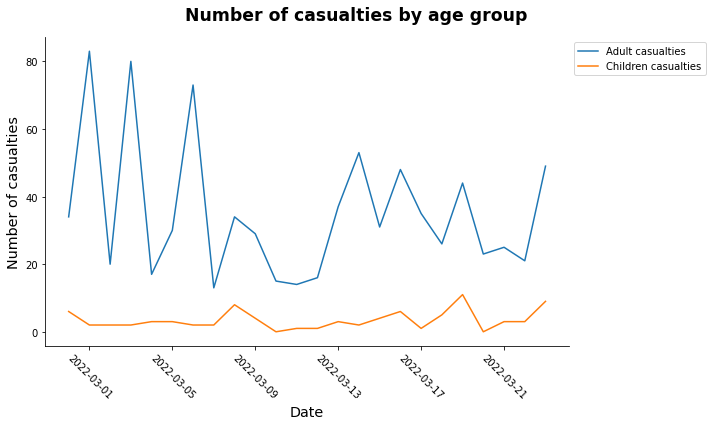

In [14]:
#same plot as above but only for articles with keywords
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
datecount = pd.DataFrame(pd.to_datetime(df[df.hasKeyword == True]['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
datecount2 = pd.DataFrame(pd.to_datetime(df['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
plt.plot(datecount.Date[4:], adultDeaths[:-3], label='Adult casualties')
plt.plot(datecount.Date[4:], childrenDeaths[:-3], label='Children casualties')
plt.xticks(rotation=-45)
plt.xlabel('Date', fontsize='x-large')
plt.ylabel('Number of casualties', fontsize='x-large')
plt.suptitle('Number of casualties by age group', weight='bold', fontsize='xx-large')

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()

plt.savefig('Figures/casualtiesbydayandage.png', dpi=300)

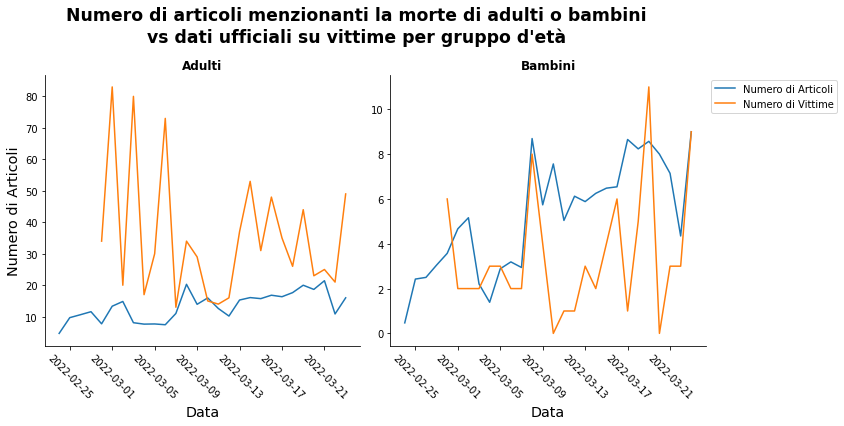

In [17]:
#same plot as above but only for articles with keywords
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
ax = plt.subplot(121)
plt.title('Adulti',  weight='bold', fontsize='large')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
datecount = pd.DataFrame(pd.to_datetime(df[df.hasKeyword == True]['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
datecount2 = pd.DataFrame(pd.to_datetime(df['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
# plt.plot(datecount.Date, datecount.Count / datecount2.Count * 100, label='Articles')
datecountAdults = pd.DataFrame(pd.to_datetime(df[df.hasKeywordAdult == True]['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
plt.plot(datecount.Date, datecountAdults.Count / datecount2.Count * 100, label='Number of articles')
plt.plot(datecount.Date[4:], adultDeaths[:-3], label='Number of casualties')
# plt.plot(datecount.Date[4:], childrenDeaths[:-3], label='Children')
plt.xticks(rotation=-45)
plt.xlabel('Data', fontsize='x-large')
plt.ylabel('Numero di Articoli', fontsize='x-large')
plt.suptitle('Number of articles contaning mentioning death adults/children by day\nagainst real number of deaths by age group', weight='bold', fontsize='xx-large')
plt.subplot(1,2,2)
ax = plt.subplot(122)
plt.title('Bambini', weight='bold', fontsize='large')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
datecount = pd.DataFrame(pd.to_datetime(df[df.hasKeyword == True]['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
datecount2 = pd.DataFrame(pd.to_datetime(df['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
plt.plot(datecount.Date, datecount.Count / datecount2.Count * 100, label='Numero di Articoli')
# datecountAdults = pd.DataFrame(pd.to_datetime(df[df.hasKeywordAdult == True]['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
# plt.plot(datecount.Date[4:], adultDeaths[:-3], label='Adults')
# plt.plot(datecount.Date, datecountAdults.Count / datecount2.Count * 100, label='Articles Adults')
plt.plot(datecount.Date[4:], childrenDeaths[:-3], label='Numero di Vittime')
plt.xticks(rotation=-45)
plt.xlabel('Data', fontsize='x-large')
# plt.ylabel('Number of Articles', fontsize='x-large')
plt.suptitle('Number of articles contaning mentions of death adults/children by day\nagainst real number of deaths by age group', weight='bold', fontsize='xx-large')
plt.suptitle('Numero di articoli menzionanti la morte di adulti o bambini\nvs dati ufficiali su vittime per gruppo d\'età', weight='bold', fontsize='xx-large')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('Figures/articlesandcasualtiesperdaybysource.png', dpi=300)

There is a different trend. How many death per articles by age group?

In [16]:
adultAdjusted = ((datecountAdults.Count / datecount2.Count * 100)[4:] / totalDeaths[:-3]).replace(np.inf, np.nan)
childrenAdjusted = ((datecount.Count / datecount2.Count * 100)[4:] / childrenDeaths[:-3]).replace(np.inf,np.nan)

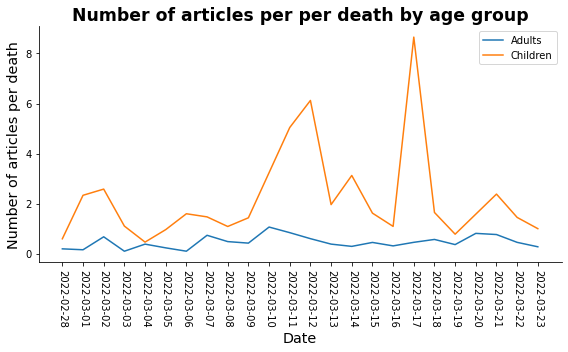

In [17]:
plt.figure(figsize=(8,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(adultAdjusted.dropna(), label='Adults')
plt.plot(childrenAdjusted.dropna(), label='Children')
plt.xticks(range(4,28), datecount.Date[4:], rotation=-90)
plt.xlabel('Date', fontsize='x-large')
plt.ylabel('Number of articles per death', fontsize='x-large')
plt.title('Number of articles per per death by age group', fontsize='xx-large', weight = 'bold')
plt.legend()
plt.tight_layout()

plt.savefig('Figures/articlesanddeathsbyage.png', dpi=300)

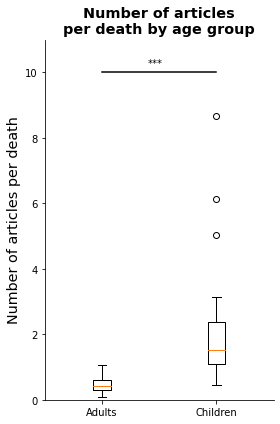

In [18]:
plt.figure(figsize=(4,6))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.boxplot([adultAdjusted.dropna(), childrenAdjusted.dropna()], labels=['Adults','Children'])
plt.title('Number of articles\nper death by age group', weight='bold', fontsize='x-large')
plt.ylabel('Number of articles per death', fontsize='x-large')
plt.axhline(10,0.25, 0.75, color='black')
plt.text(s='***',x =  1.4, y=10.2)
plt.ylim(0,11)
plt.tight_layout()

plt.savefig('Figures/articlesperdeathboxplot.png', dpi=300)

In [19]:
# one-sided t-test by day to see if results are significantly different
temp = pd.DataFrame(np.transpose([adultAdjusted, childrenAdjusted]), columns=['adultAdjusted','childrenAdjusted']).dropna()
stats.ttest_ind(temp.childrenAdjusted, temp.adultAdjusted, alternative='greater')

Ttest_indResult(statistic=4.182416122447111, pvalue=7.174898190009683e-05)

In [20]:
# We need this only for the post hoc power analysis
a = adultAdjusted
b = childrenAdjusted
b = pd.Series([x for  x in b if x != np.inf])
a.mean(), a.std(), b.mean(), b.std(), len(a), len(b), stats.pearsonr(temp.adultAdjusted, temp.childrenAdjusted)

(0.4629940588277813,
 0.2521884595400143,
 2.2043496139832706,
 1.990093492491546,
 24,
 24,
 (0.372496566585, 0.0877761875655288))

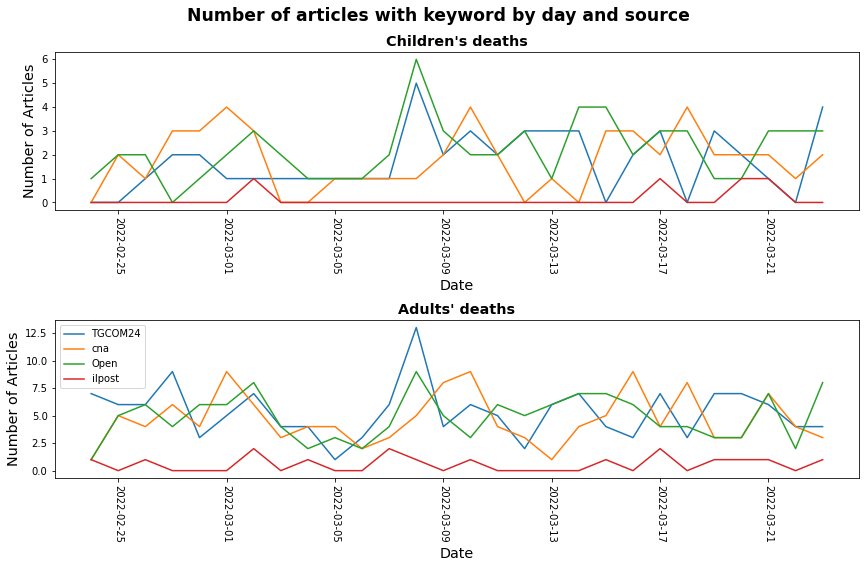

In [21]:
#see the number of articles by source
plt.figure(figsize=(12,8))

plt.suptitle('Number of articles with keyword by day and source', fontsize='xx-large', weight = 'bold')
plt.subplot(2,1,1)
plt.title('Children\'s deaths', fontsize='x-large', weight = 'bold')
for source in df.Source.unique():
    x, y = [], []
    for date in df.Date.unique():
        x.append(date)
        y.append(len(df[(df.Source == source) & (df.hasKeyword) & (df.Date == date)]))
    plt.plot(x, y , label=source)
    
plt.xticks(rotation=-90)

plt.xlabel('Date', fontsize='x-large', )
plt.ylabel('Number of Articles', fontsize='x-large')

plt.subplot(2,1,2)
plt.title('Adults\' deaths', fontsize='x-large', weight = 'bold')
for source in df.Source.unique():
    x, y = [], []
    for date in df.Date.unique():
        x.append(date)
        y.append(len(df[(df.Source == source) & (df.hasKeywordAdult) & (df.Date == date)]))
    plt.plot(x, y , label=source)
    
plt.xticks(rotation=-90)
plt.xlabel('Date', fontsize='x-large', )
plt.ylabel('Number of Articles', fontsize='x-large',)
plt.legend()
plt.tight_layout()